In [ ]:
!pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import torch.nn.functional as F
import csv

# GPT2 with Fine Tuning

### Prepare data

In [ ]:
lyrics = pd.read_csv('/content/drive/MyDrive/lyrics-data.csv')
# lyrics = lyrics[lyrics['Idiom']=='ENGLISH']
lyrics

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt
...,...,...,...,...,...
379926,/clegg-johnny/,The Waiting,/clegg-johnny/the-waiting.html,Chorus\nHere we stand waiting on the plain\nDa...,en
379927,/clegg-johnny/,Too Early For The Sky,/clegg-johnny/too-early-for-the-sky.html,I nearly disappeared into the mouth of a croco...,en
379928,/clegg-johnny/,Warsaw 1943 (I Never Betrayed The Revolution),/clegg-johnny/warsaw-1943-i-never-betrayed-the...,"Amambuka, amambuka azothengisa izwe lakithi, i...",en
379929,/clegg-johnny/,When The System Has Fallen,/clegg-johnny/when-the-system-has-fallen.html,Sweat in the heat for days on end\nwaiting for...,en


In [ ]:
#Only keep popular artists, with genre Rock/Pop and popularity high enough
artists = pd.read_csv('/content/drive/MyDrive/artists-data.csv')
artists
artists = artists[(artists['Genres'].isin(['Rock'])) & (artists['Popularity']>5)]

In [ ]:
df = lyrics.merge(artists[['Artist', 'Genres', 'Link']], left_on='ALink', right_on='Link', how='inner')

In [ ]:
df = df.drop(columns=['ALink','SLink','Link'])

In [ ]:
#Drop the songs with lyrics too long (after more than 1024 tokens, does not work)
df = df[df['Lyric'].apply(lambda x: len(x.split(' ')) < 350)]

In [ ]:
len(df)

934

In [ ]:
df.columns

Index(['SName', 'Lyric', 'language', 'Artist', 'Genres'], dtype='object')

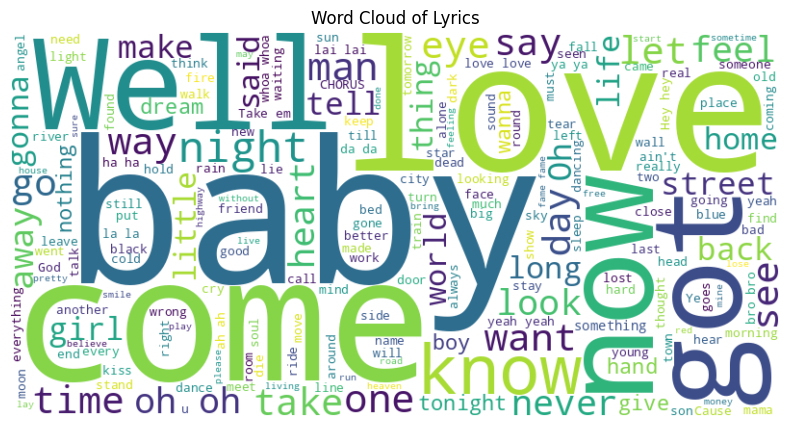

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word cloud for lyrics
lyrics_text = ' '.join(df['Lyric'])
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(lyrics_text)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Lyrics')
plt.show()


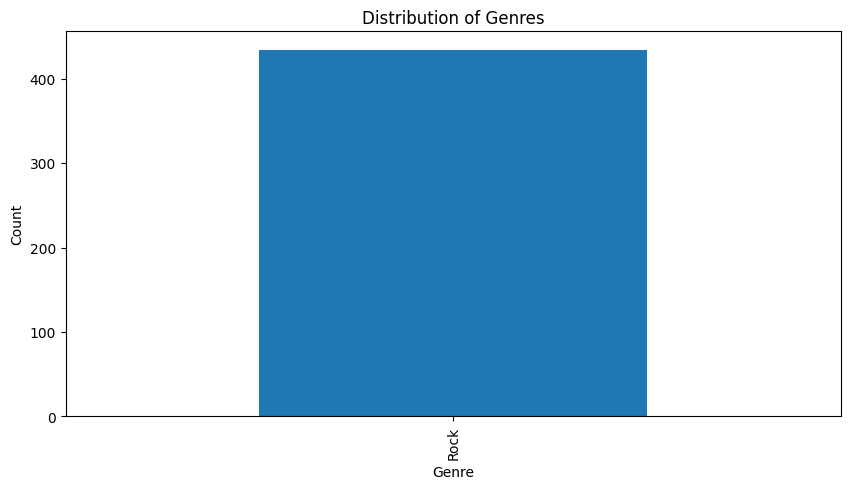

In [ ]:
# Plot genre distribution
plt.figure(figsize=(10, 5))
df['Genres'].value_counts().plot(kind='bar')
plt.title('Distribution of Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()


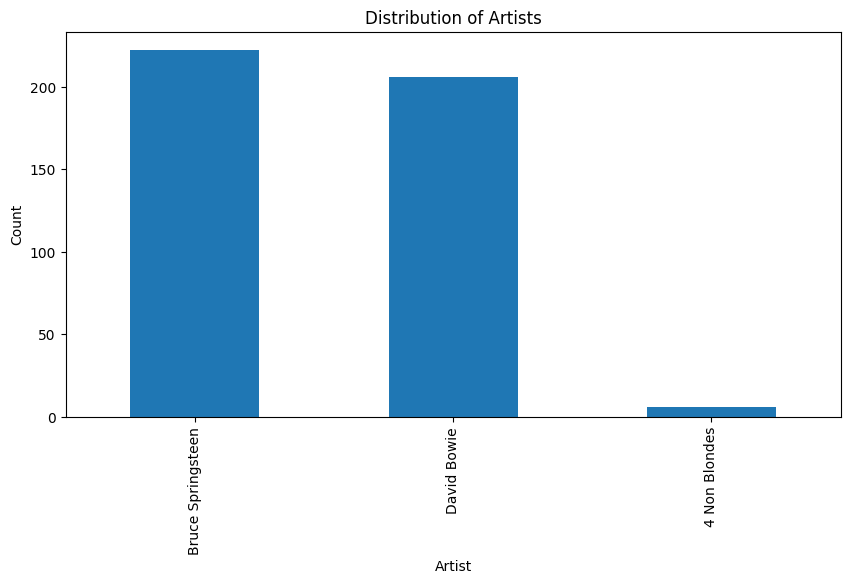

In [ ]:
# Plot artist distribution
plt.figure(figsize=(10, 5))
df['Artist'].value_counts().plot(kind='bar')
plt.title('Distribution of Artists')
plt.xlabel('Artist')
plt.ylabel('Count')
plt.show()


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

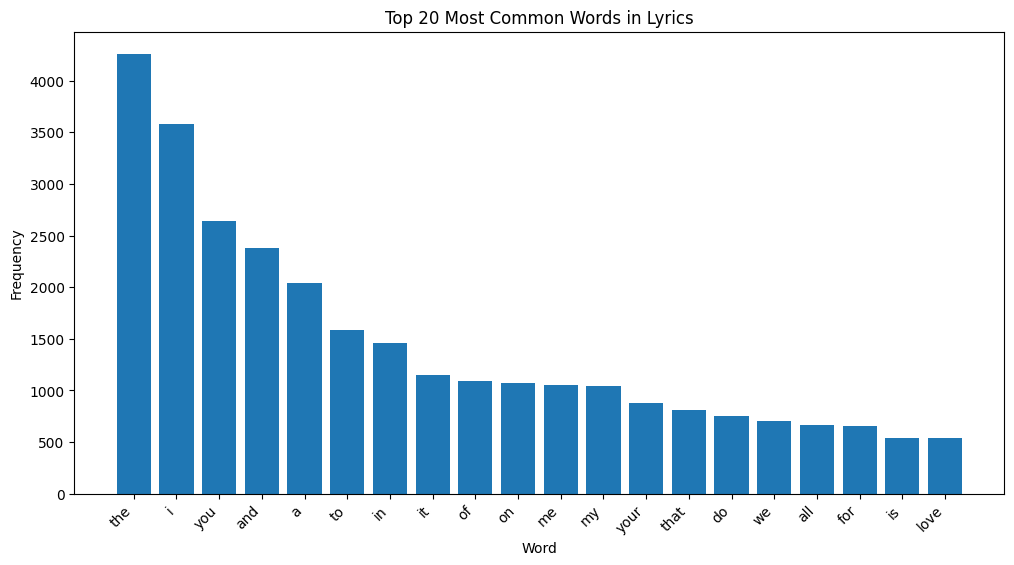

In [ ]:
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize

# Tokenize the lyrics into words
all_lyrics = ' '.join(df['Lyric'])
tokens = word_tokenize(all_lyrics.lower())

# Remove punctuation and non-alphabetic tokens
tokens = [word for word in tokens if word.isalpha()]

# Calculate word frequencies
word_freq = Counter(tokens)

# Get the top N most frequent words
top_n = 20
top_words = word_freq.most_common(top_n)

# Plot the word frequency distribution
plt.figure(figsize=(12, 6))
plt.bar([word[0] for word in top_words], [word[1] for word in top_words])
plt.title(f'Top {top_n} Most Common Words in Lyrics')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


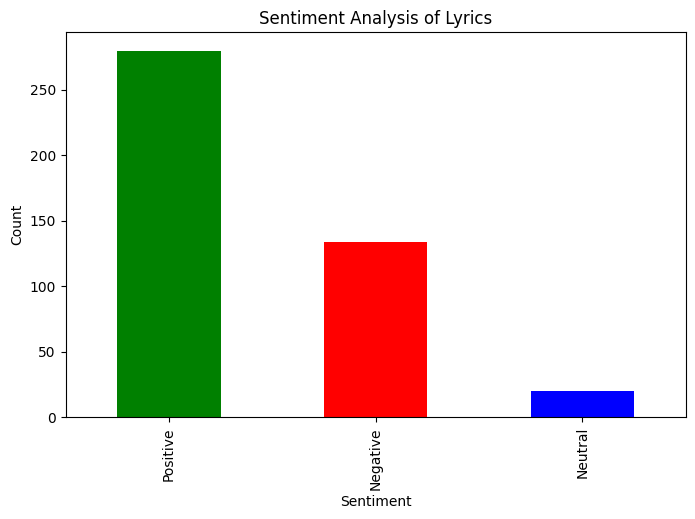

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download the VADER lexicon if necessary
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Perform sentiment analysis on each lyric
sentiments = []
for lyric in df['Lyric']:
    # Get sentiment scores for the lyric
    sentiment_scores = sid.polarity_scores(lyric)
    # Classify the sentiment as positive, negative, or neutral based on compound score
    if sentiment_scores['compound'] > 0.05:
        sentiment = 'Positive'
    elif sentiment_scores['compound'] < -0.05:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'
    sentiments.append(sentiment)

# Add the sentiments to the dataframe
df['Sentiment'] = sentiments

# Plot the distribution of sentiments
plt.figure(figsize=(8, 5))
df['Sentiment'].value_counts().plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Sentiment Analysis of Lyrics')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [ ]:
#Create a very small test set to compare generated text with the reality
test_set = df.sample(n = 500)
df = df.loc[~df.index.isin(test_set.index)]

#Reset the indexes
test_set = test_set.reset_index()
df = df.reset_index()

In [ ]:
#For the test set only, keep last 20 words in a new column, then remove them from original column
test_set['True_end_lyrics'] = test_set['Lyric'].str.split().str[-20:].apply(' '.join)
test_set['Lyric'] = test_set['Lyric'].str.split().str[:-20].apply(' '.join)

In [ ]:
test_set.head()

,index,SName,Lyric,language,Artist,Genres,True_end_lyrics
0,75,Baby Can Dance,I'm rolling out of the ferris wheel No one loo...,en,David Bowie,Rock,nowhere Baby can dance Baby can dance Baby can...
1,60,Almost Grown,(Anyway I'm almost grown) Yeah 'n' I'm doin' a...,en,David Bowie,Rock,wanna take her to the dance Sit and talk about...
2,483,Secret Garden,She'll let you in her house If you come knocki...,en,Bruce Springsteen,Rock,She's got a secret garden Where everything you...
3,107,Candidate (Demo),Inside every teenage girl there's a fountain I...,en,David Bowie,Rock,"For your future's sake, I'm the candidate Let'..."
4,861,Straight Time,Got out of prison back in '86 and I found a wi...,en,Bruce Springsteen,Rock,get the smell from my hands Lay my head down o...


### Prepare the dataset

In [ ]:
class SongLyrics(Dataset):

    def __init__(self, control_code, truncate=False, gpt2_type="gpt2", max_length=1024):

        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_type)
        self.lyrics = []

        for row in df['Lyric']:
          self.lyrics.append(torch.tensor(
                self.tokenizer.encode(f"<|{control_code}|>{row[:max_length]}<|endoftext|>")
            ))

        if truncate:
            self.lyrics = self.lyrics[:20000]
        self.lyrics_count = len(self.lyrics)

    def __len__(self):
        return self.lyrics_count

    def __getitem__(self, item):
        return self.lyrics[item]

In [ ]:
dataset = SongLyrics(df['Lyric'], truncate=True, gpt2_type="gpt2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
dataset

### Prepare training

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
#Accumulated batch size (since GPT2 is so big)
def pack_tensor(new_tensor, packed_tensor, max_seq_len):
    if packed_tensor is None:
        return new_tensor, True, None
    if new_tensor.size()[1] + packed_tensor.size()[1] > max_seq_len:
        return packed_tensor, False, new_tensor
    else:
        packed_tensor = torch.cat([new_tensor, packed_tensor[:, 1:]], dim=1)
        return packed_tensor, True, None

In [ ]:
def train(
    dataset, model, tokenizer,
    batch_size=16, epochs=20, lr=2e-5,
    max_seq_len=400, warmup_steps=200,
    gpt2_type="gpt2", output_dir=".", output_prefix="wreckgar",
    test_mode=False,save_model_on_epoch=False,
):

    acc_steps = 100
    device=torch.device("cuda")
    model = model.cuda()
    model.train()

    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=-1
    )

    train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    loss=0
    accumulating_batch_count = 0
    input_tensor = None

    for epoch in range(epochs):

        print(f"Training epoch {epoch}")
        print(loss)
        for idx, entry in tqdm(enumerate(train_dataloader)):
            (input_tensor, carry_on, remainder) = pack_tensor(entry, input_tensor, 768)

            if carry_on and idx != len(train_dataloader) - 1:
                continue

            input_tensor = input_tensor.to(device)
            outputs = model(input_tensor, labels=input_tensor)
            loss = outputs[0]
            loss.backward()

            if (accumulating_batch_count % batch_size) == 0:
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                model.zero_grad()

            accumulating_batch_count += 1
            input_tensor = None
        if save_model_on_epoch:
            torch.save(
                model.state_dict(),
                os.path.join(output_dir, f"{output_prefix}-{epoch}.pt"),
            )
    return model

### Actual Training

In [ ]:
#Train the model on the specific data we have
model = train(dataset, model, tokenizer)

In [ ]:
#Save the model to a pkl or something so it can be reused later on
torch.save(model, '/content/drive/MyDrive/model_lyrics.pt')

### Text generation

In [ ]:
#Load the model to use it
model = torch.load('/content/drive/MyDrive/model_lyrics.pt')

In [ ]:
def generate(
    model,
    tokenizer,
    prompt,
    entry_count=10,
    entry_length=30, #maximum number of words
    top_p=0.8,
    temperature=1.,
):

    model.eval()

    generated_num = 0
    generated_list = []

    filter_value = -float("Inf")

    with torch.no_grad():

        for entry_idx in trange(entry_count):

            entry_finished = False

            generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)

            for i in range(entry_length):
                outputs = model(generated, labels=generated)
                loss, logits = outputs[:2]
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)

                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                    ..., :-1
                ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value

                next_token = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
                generated = torch.cat((generated, next_token), dim=1)

                if next_token in tokenizer.encode("<|endoftext|>"):
                    entry_finished = True

                if entry_finished:

                    generated_num = generated_num + 1

                    output_list = list(generated.squeeze().numpy())
                    output_text = tokenizer.decode(output_list)
                    generated_list.append(output_text)
                    break

            if not entry_finished:
              output_list = list(generated.squeeze().numpy())
              output_text = f"{tokenizer.decode(output_list)}<|endoftext|>"
              generated_list.append(output_text)

    return generated_list

In [ ]:
#Function to generate multiple sentences. Test data should be a dataframe
def text_generation(test_data):
  generated_lyrics = []
  for i in range(len(test_data)):
    x = generate(model.to('cpu'), tokenizer, test_data['Lyric'][i], entry_count=1)
    print(x)
    generated_lyrics.append(x)
  return generated_lyrics

In [ ]:
tokenizer

GPT2Tokenizer(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

In [ ]:
test_set['Lyric'][1]

"(Anyway I'm almost grown) Yeah 'n' I'm doin' all right in school They ain't said I broke no rule I ain't never been in Dutch I don't browse around too much Don't bother, leave us alone Anyway we're almost grown I don't run around with no mob Got myself a little job I'm gonna buy me a little car Drive my girlfriend in the park Don't bother, leave us alone Anyway we're almost grown Got my eye on a little girl Oh man, she's out of this world I"

In [ ]:
test_set

In [ ]:
# Remove rows with None or NaN values
test_set.dropna(inplace=True)

# Remove rows with empty strings
test_set = test_set[test_set['Lyric'].astype(bool)]

# Reset index after removing rows
test_set.reset_index(drop=True, inplace=True)

In [ ]:
generated_lyrics = text_generation(test_set[:11])

100%|██████████| 1/1 [00:42<00:00, 42.16s/it]


["I'm rolling out of the ferris wheel No one looks and no one feels But the baby can the baby can The way it feels just feeling you Holding out and falling out But the baby can the baby can I'm the jumping man I'm the jumping man But baby can float Baby can drown Baby can touch her toes Toss her hair Makes you feel you're going nowhere Baby can dance Baby can dance Baby can walk around the town Attract a man and cut him down I'm the shadow man the jumping jack The man who can and don't look back But the baby can the baby can I'm rolling out of the ferris wheel No one looks and no one feels But the baby can the baby can And the way it feels I'm feeling you But baby can float Baby can drown Baby can touch her toes Toss her hair Makes you feel you're going nowhere Baby can dance Baby can dance Baby can walk around the town Attract a man and cut him down Everyday is far away Everyday, everyday It's over now It's over now It's over now It's over now It's over now But baby can float Baby can

100%|██████████| 1/1 [00:16<00:00, 16.01s/it]


["(Anyway I'm almost grown) Yeah 'n' I'm doin' all right in school They ain't said I broke no rule I ain't never been in Dutch I don't browse around too much Don't bother, leave us alone Anyway we're almost grown I don't run around with no mob Got myself a little job I'm gonna buy me a little car Drive my girlfriend in the park Don't bother, leave us alone Anyway we're almost grown Got my eye on a little girl Oh man, she's out of this world I'm going to try and be the man I want to be I'm going to do things I've never done before and I'm almost grown She's<|endoftext|>"]


100%|██████████| 1/1 [00:23<00:00, 23.51s/it]


["She'll let you in her house If you come knockin' late at night She'll let you in her mouth If the words you say are right If you pay the price She'll let you deep inside But there's a secret garden she hides She'll let you in her car To go drivin' 'round She'll let you into the parts of herself That'll bring you down She'll let you in her heart If you got a hammer and a vise But into her secret garden, don't think twice You've gone a million miles How far'd you get To that place where you can't remember And you can't forget She'll lead you down a path There'll be tenderness in the air She'll let you come just far enough So you know she's really there She'll look at you and smile And her eyes will say, 'My darling you're such a darling'\n'Poor Valentine, you're still alive\nAnd she said, 'Tell me, is this<|endoftext|>"]


100%|██████████| 1/1 [00:25<00:00, 25.75s/it]


["Inside every teenage girl there's a fountain Inside every young pair of pants there's a mountain Inside every mother's eyes is Tommy Tinkrem's bed Inside every candidate waits a grateful dead I make it a thing, when I'm on my own to relieve myself I make it a thing, when I gazelle on stage to believe in myself I make it a thing, to glance in window panes and look pleased with myself Yeah, and pretend I'm walking home I took it so bad, I sat in the correction room Took me a fag, and a kick in the moon Well, I ain't gonna suck no radar wing Because inside this tin is tin Would you like to techno-plate cause I'm your candidate Oh yeah It's a matter of life And the way you walk, you've got a BrylCream queen It's a matter of tact In the things you talk, that keeps his passport clean A matter of fact That a cock ain't a cock on a twelve inch screen So I'll pretend I'm walking home You don't have to scream a lot to keep an age in tune You don't have to scream a lot to predict monsoons You d

100%|██████████| 1/1 [00:33<00:00, 33.93s/it]


['Got out of prison back in \'86 and I found a wife Walked the clean and narrowJust tryin\' to stay out and stay alive Got a job at the rendering plant, it ain\'t gonna make me rich In the darkness before dinner comes Sometimes I can feel the itch I got a cold mind to go tripping across that thin line I\'m sick of doin\' straight time My uncle\'s at the evenin\' table, makes his living runnin\' hot cars Slips me a hundred dollar bill says "Charlie you best remember who your friends are. "Got a cold mind to go trippin\' \'cross that thin line I ain\'t makin\' straight time Eight years in it feels like you\'re gonna die But you get used to anything Sooner or later it just becomes your life Kitchen floor in the evening tossin\' my little babies high Mary\'s smiling but she\'s watching me out of the corner of her eye Seems you can\'t get any more than half free I step out onto the front porch and suck the cold air deep inside of me Got a cold mind to go trippin\' \'cross that thin line I\'

100%|██████████| 1/1 [00:25<00:00, 25.56s/it]


["There's a place out on the highway 'cross the San Bernardino line Where the truckers and the bikers gather every night at the same time At seven the band comes in and locals dance the night away At Sleepy Joe's Café I drive on down from the big town Friday when the clock strikes five As the red sun sets in the ocean, I start to come alive Summer girls in the parking lot slap on their makeup and they flirt the night away Sleepy Joe's Café Joe came home in '45 and took out a G. I. loan On a sleepy little spot an Army cook could call his own He married May, the highway come in and they woke up to find They were sitting on top of a pretty little gold mine Saturday night the lights are bright as the folks pour in from town Joe keeps the blues playin', at the bar May lays the beers down I come through the door and feel the workweek slip away See you out on the town Bob and I roll down the window one night and he dances his hair back in a tired groove He comes back and says I'm on the sound

100%|██████████| 1/1 [00:56<00:00, 56.69s/it]


["You remind me of the babe. (What babe?) The babe with the power. (What power?) The Power of voodoo. (who do?) You do? (Do what?) Remind me of the babe. I saw my baby, crying hard as babes could cry What could I do? My baby's love had gone And left my baby blue Nobody knew! What kind of magic spell 'd'you use? Slime and snails Or puppy dog tails? Thunder or lightning Then baby said Dance magic, dance (dance magic, dance) Dance magic, dance (dance magic, dance) Put that baby's spell on me Jump magic, jump (jump magic, jump) Jump magic, jump (jump magic, jump) Put that magic jump on me Slap that baby, make him free! I saw my baby, trying hard as babes could try What could I do? My baby's fun had gone And left my baby blue Nobody knew Dance magic, dance (dance magic, dance) (x4) Jump magic, jump (jump magic, jump) (x2) Put that baby's spell on me (ooh) You remind me of the babe What babe? The babe with the power. (What power?) The power of voodoo. (voodoo?) You do? (Do what?) Remind me o

100%|██████████| 1/1 [00:31<00:00, 31.94s/it]


['We fell in love and I made you the world I spent all my time tryin\' to satisfy you, girl Just one thing that I can\'t figure out [?] Closer I get, farther baby I am out [?] 30 days, 30 days out Well I\'m six days runnin\' but I\'m 30 days out 30 days, 30 days out With every kiss you leave a little shadow of doubt The roof was leakin\' honey where we live And I\'m wonderin\' what\'s that something that you won\'t give I started loving you but I gotta stop You got me mostly waitin\' for that other shoe to drop 30 days, 30 days out You keep me six days runnin\' but I\'m 30 days out 30 days, 30 days out With every kiss you leave a little shadow of doubt Tried to talk about what\'s goin\' on You just smile and tell me "Baby there ain\'t nothin\' wrong" In your smile there\'s a sign in red It said "Thousand miles of hard road dead ahead" 30 days, 30 days out Yeah I\'m six days runnin\' but I\'m 30 days out 30 days, 30 days out With every kiss you leave a little shadow of doubt 30 days, 30

100%|██████████| 1/1 [00:43<00:00, 43.96s/it]


["Golden years, gold whop whop whop Golden years, gold whop whop whop Golden years, gold whop whop whop Don't let me hear you say life's taking you nowhere, angel Come get up my baby Look at that sky, life's begun Nights are warm and the days are young Come get up my baby There's my baby, lost that's all Once I'm begging you save her little soul Golden years, gold whop whop whop Come get up my baby Last night they loved you, opening doors and pulling some strings, angel Come get up my baby In walked luck and you looked in time Never look back, walk tall, act fine Come get up my baby I'll stick with you baby for a thousand years Nothing's gonna touch you in these golden years, gold Golden years, gold whop whop whop Come get up my baby Some of these days, and it won't be long Gonna drive back down where you once belonged In the back of a dream car twenty foot long Don't cry my sweet, don't break my heart Doing all right, but you gotta get smart Wish upon, wish upon, day upon day, I belie

100%|██████████| 1/1 [00:57<00:00, 57.67s/it]


["Taking it all the right way Keeping it in the back Taking it all the right way Never no turning back Never need, no Never no turning back Flying just a sweet place Coming inside and safe Flying just a sweet place Never been known to fail Never been, no Never been known to fail Wishing you, wishing that sometimes (sometimes) Doing it, doing it right, 'till, ahh time, (one time) Gets you when you're down (nobody, nobody, do it again, get off) Ahhh, sometimes, (doing) Wishing sometimes (give it back) Up there, up there (giving it) Oh, my darling (No) Ah, my darling, (giving it) ah (up there) why? (Gimme, gimme) up there, (yeah) gimme, (doing) Taking with me (sometimes) Loving it, doing it (right) 'till (take it) one time Gimme (doing it) Giving it (giving it back) Taking it all the right way (taking it) Keeping it in the back (hey hey) Taking it all the right way Never no turning back (never never never never) Never no turning back Taking it all the right way Keeping it in the back Taki

100%|██████████| 1/1 [00:20<00:00, 20.80s/it]

["She'll come, she'll go. She'll lay belief on you Skin sweet with musky odour The lady from another grinning soul Cologne she'll wear. Silver and americard She'll drive a beetle car And beat you down at cool canasta And when the clothes are strewn Don't be afraid of the room Touch the fullness of her breast. Feel the love of her caress She will be your living end She'll come, she'll go. She'll lay belief on you But she won't stake her life on you How can life become her point of view And when the clothes are strewn Don't be afraid of the room Touch the fullness of her breast. Feel the love of her caress She will be your living end She will be your hiding place In your voice and in your body\n\nCarolina, where I used to live, is now taken by the nation to Hollywood.\n<|endoftext|>"]


In [ ]:
test_set.columns

Index(['index', 'SName', 'Lyric', 'language', 'Artist', 'Genres',
       'True_end_lyrics'],
      dtype='object')

In [ ]:
#Loop to keep only generated text and add it as a new column in the dataframe
test_set= test_set[:11]
my_generations=[]

for i in range(len(generated_lyrics)):
  a = test_set['Lyric'][i].split()[-30:] #Get the matching string we want (30 words)
  b = ' '.join(a)
  c = ' '.join(generated_lyrics[i]) #Get all that comes after the matching string
  my_generations.append(c.split(b)[-1])

test_set['Generated_lyrics'] = my_generations

In [ ]:
test_set

,index,SName,Lyric,language,Artist,Genres,True_end_lyrics,Generated_lyrics
0,75,Baby Can Dance,I'm rolling out of the ferris wheel No one loo...,en,David Bowie,Rock,nowhere Baby can dance Baby can dance Baby can...,nowhere Baby can dance Baby can dance Baby ca...
1,60,Almost Grown,(Anyway I'm almost grown) Yeah 'n' I'm doin' a...,en,David Bowie,Rock,wanna take her to the dance Sit and talk about...,'m going to try and be the man I want to be I'...
2,483,Secret Garden,She'll let you in her house If you come knocki...,en,Bruce Springsteen,Rock,She's got a secret garden Where everything you...,", 'My darling you're such a darling'\n'Poor Va..."
3,107,Candidate (Demo),Inside every teenage girl there's a fountain I...,en,David Bowie,Rock,"For your future's sake, I'm the candidate Let'...",\n\nShare this: Facebook\n\nTwitter\n\nGoogle\...
4,861,Straight Time,Got out of prison back in '86 and I found a wi...,en,Bruce Springsteen,Rock,get the smell from my hands Lay my head down o...,"sleep What a lonely, lonely heart it's to com..."
5,841,Sleepy Joe's Cafe,There's a place out on the highway 'cross the ...,en,Bruce Springsteen,Rock,floor and Monday morning's a million miles awa...,town Bob and I roll down the window one night...
6,266,Magic Dance,You remind me of the babe. (What babe?) The ba...,en,David Bowie,Rock,"dance) Dance magic, dance Slap that slap that ...","dance) Dance magic, dance (dance magic, dance..."
7,503,30 Days Out,We fell in love and I made you the world I spe...,en,Bruce Springsteen,Rock,"but I'm 30 days out 30 days, 30 days out With ...","but I'm 30 days out 30 days, 30 days out Your..."
8,166,Golden Years,"Golden years, gold whop whop whop Golden years...",en,David Bowie,Rock,a thousand years Nothing's gonna touch you in ...,a thousand years Well the boy returns to his ...
9,320,Right,Taking it all the right way Keeping it in the ...,en,David Bowie,Rock,"(Never no turning back) (I never, I never, I n...","(Never no turning back) (Never, never, never)..."


In [ ]:
len(my_generations)

11

In [ ]:
final = []

for lyric in test_set['Generated_lyrics']:
    # Split the lyric by whitespace
    words = lyric.split()
    # Take the first 20 words
    first_20_words = ' '.join(words[:30])
    final.append(first_20_words)

test_set['Generated_lyrics'] = final


In [ ]:
test_set

,index,SName,Lyric,language,Artist,Genres,True_end_lyrics,Generated_lyrics
0,75,Baby Can Dance,I'm rolling out of the ferris wheel No one loo...,en,David Bowie,Rock,nowhere Baby can dance Baby can dance Baby can...,nowhere Baby can dance Baby can dance Baby can...
1,60,Almost Grown,(Anyway I'm almost grown) Yeah 'n' I'm doin' a...,en,David Bowie,Rock,wanna take her to the dance Sit and talk about...,'m going to try and be the man I want to be I'...
2,483,Secret Garden,She'll let you in her house If you come knocki...,en,Bruce Springsteen,Rock,She's got a secret garden Where everything you...,", 'My darling you're such a darling' 'Poor Val..."
3,107,Candidate (Demo),Inside every teenage girl there's a fountain I...,en,David Bowie,Rock,"For your future's sake, I'm the candidate Let'...",Share this: Facebook Twitter Google Pinterest ...
4,861,Straight Time,Got out of prison back in '86 and I found a wi...,en,Bruce Springsteen,Rock,get the smell from my hands Lay my head down o...,"sleep What a lonely, lonely heart it's to come..."
5,841,Sleepy Joe's Cafe,There's a place out on the highway 'cross the ...,en,Bruce Springsteen,Rock,floor and Monday morning's a million miles awa...,town Bob and I roll down the window one night ...
6,266,Magic Dance,You remind me of the babe. (What babe?) The ba...,en,David Bowie,Rock,"dance) Dance magic, dance Slap that slap that ...","dance) Dance magic, dance (dance magic, dance)..."
7,503,30 Days Out,We fell in love and I made you the world I spe...,en,Bruce Springsteen,Rock,"but I'm 30 days out 30 days, 30 days out With ...","but I'm 30 days out 30 days, 30 days out Your ..."
8,166,Golden Years,"Golden years, gold whop whop whop Golden years...",en,David Bowie,Rock,a thousand years Nothing's gonna touch you in ...,a thousand years Well the boy returns to his c...
9,320,Right,Taking it all the right way Keeping it in the ...,en,David Bowie,Rock,"(Never no turning back) (I never, I never, I n...","(Never no turning back) (Never, never, never) ..."


In [ ]:
test_set['Generated_lyrics'][10]

'hiding place In your voice and in your body Carolina, where I used to live, is now taken by the'

In [ ]:
test_set['True_end_lyrics'][10]

'living end She will be your living end She will be your living end She will be your living end'

### Analyze performance

In [ ]:
!pip install rouge

In [ ]:
#Rouge score
from rouge import Rouge
rouge=Rouge()

rouge.get_scores(test_set['Generated_lyrics'], test_set['True_end_lyrics'], avg=True)

{'rouge-1': {'r': 0.3033454290807232,
  'p': 0.33020999468367895,
  'f': 0.3044466516322688},
 'rouge-2': {'r': 0.2052139037433155,
  'p': 0.24613673220484367,
  'f': 0.2159833608513492},
 'rouge-l': {'r': 0.2987999745352687,
  'p': 0.3245281765018608,
  'f': 0.2993961465817638}}